In [8]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np


In [9]:
class AAE:
  def __init__(self, latent_dim, input_shape, input_length, kernel_size, strides, filters, discriminator_dims, keep_prob, ae_lr, dc_lr, gen_lr):
    super(AAE, self).__init__()
    self.latent_dim = latent_dim
    self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=ae_lr)
    self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_lr)
    self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=dc_lr)
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
    self.stride_reduction = strides[0]*strides[1]

    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=input_shape),
          tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], activation='relu'),
          tf.keras.layers.Dropout(keep_prob),
          tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], activation='relu'),
          tf.keras.layers.Dropout(keep_prob),
          tf.keras.layers.Flatten(),
          # Obtain mu e log_var
          tf.keras.layers.Dense(latent_dim + latent_dim)
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=latent_dim),
          tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*32/self.stride_reduction**2), activation='relu'),
          tf.keras.layers.Reshape(target_shape=(int(input_shape[0]/self.stride_reduction), int(input_shape[1]/self.stride_reduction), 32)),
          tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], activation='relu', padding='same'),
          tf.keras.layers.Dropout(keep_prob),
          tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], activation='relu', padding='same'),
          tf.keras.layers.Dropout(keep_prob),
          tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same'),
        ]
    )

    self.discriminator = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(discriminator_dims[0], activation='relu'),
          tf.keras.layers.Dropout(keep_prob),
          tf.keras.layers.Dense(discriminator_dims[1], activation='relu'),
          tf.keras.layers.Dropout(keep_prob),
          tf.keras.layers.Dense(1),
        ]
    )
  
  def sample(self, n_samples, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(n_samples, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
  
  def encode(self, x, training=False):
    mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
    return mean, log_var

  def reparametrize(self, mean, log_var):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(log_var * .5) + mean
  
  def encode_and_reparametrize(self, x, training=False):
    mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
    return self.reparametrize(mean, log_var)

  def decode(self, z, apply_sigmoid=False, training=False):
    logits = self.decoder(z, training=training)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def log_normal_pdf(sample, mean, log_var, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-log_var) + log_var + log2pi),
        axis=raxis)

  def autoencoder_loss(self, X, training=False):
    # Generate latent space vector by encoding X
    mean_generated, log_var_generated = self.encode(X, training=training)
    z_generated = self.reparametrize(mean_generated, log_var_generated)

    # Decode
    X_generated = self.decode(z_generated, apply_sigmoid=True, training=training)

    # Autoencoder loss
    ae_loss = tf.reduce_mean(tf.math.squared_difference(X_generated, X))
    return ae_loss
    

  def generator_loss(self, real_output, training=False):
    return self.cross_entropy(tf.ones_like(real_output), real_output)

  def discriminator_loss(self, real_output, fake_output, training=False):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
  @tf.function
  def train_step(self, batch_x):
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = self.encode_and_reparametrize(batch_x, training=True)
        decoder_output = self.decode(encoder_output, apply_sigmoid=True, training=True)

        # Autoencoder loss
        ae_loss = self.autoencoder_loss(batch_x, training=True)
    
    ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
    self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

    generated_noise = tf.random.normal([batch_x.shape[0], self.latent_dim], mean=0.0, stddev=1.0)
    # Discriminator
    with tf.GradientTape() as dc_tape:
        encoder_output = self.encode_and_reparametrize(batch_x, training=True)

        dc_real = self.discriminator(encoder_output, training=True)
        dc_fake = self.discriminator(generated_noise, training=True)

        # Discriminator Loss
        dc_loss = self.discriminator_loss(dc_real, dc_fake, training=True)
        
        # Discriminator Acc
        dc_acc = self.dc_accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
    self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = self.encode_and_reparametrize(batch_x, training=True)
        dc_fake = self.discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = self.generator_loss(dc_fake, training=True)

    gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss
  
  def fit(self, train_dataset, epochs):
    past = dt.now()
    for epoch in range(epochs):
      epoch_start = dt.now()
      for train_x in train_dataset:
        ae_loss, dc_loss, dc_acc, gen_loss = self.train_step(train_x)
      epoch_end = dt.now()
      print("Epoch: {}, time elapsed: {}, AE loss: {}, Discriminator loss: {}, Discriminator accuracy: {}, Generator loss: {}".format(epoch + 1, epoch_end - epoch_start, ae_loss, dc_loss, dc_acc, gen_loss))


In [10]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') /255.
    return images


train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

aae = AAE(40, (32,32,3), 32*32*3, [3,3], [2,2], [32, 64], [400, 150], 0.5, 1e-4, 1e-4, 1e-4)
aae.fit(train_dataset, epochs=100)

TypeError: __init__() missing 1 required positional argument: 'rate'

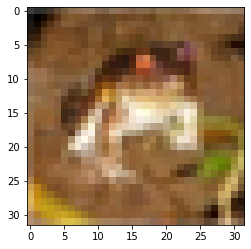

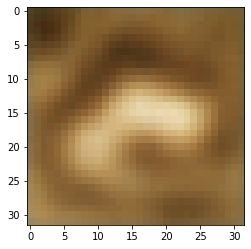

In [ ]:
from matplotlib import pyplot as plt

image = train_images[0,:,:,:].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

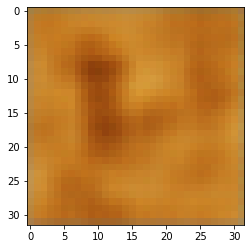

In [ ]:
import tensorflow_probability as tfp

z = np.random.rand(1,40)
image = aae.decode(z, apply_sigmoid=True).numpy()
image = image * 255.
image=image.astype('int16')
image.reshape((32,32,3))
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()